In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import numpy as np
import soundfile as sf
import sys
sys.path.insert(0, r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\AudioDataset")

from AudioDataset import AudioDataset

In [3]:
# Scieżki do plików
root_dir = r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\train\train\audio"
cache_dir = r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\cache_spectrograms"

In [4]:
# Pobranie danych i zapisaniech jako jednokolorowych spektogramów
dataset = AudioDataset(
    root_dir=root_dir,
    cache_dir=cache_dir,
    preprocess=True,    # raz przeliczy i zapisze wszystkie spektrogramy
    transform=None
)

# EDA

In [6]:
records = []
for fp, label_idx in zip(dataset.filepaths, dataset.labels):
    data, sr = sf.read(fp)
    length_s = len(data) / sr
    max_amp = data.max()
    min_amp = data.min()
    abs_max = max(abs(min_amp), abs(max_amp))
    records.append({
        'filename': os.path.basename(fp),
        'label':        dataset.idx2label[label_idx],
        'length_s':     length_s,
        'max_amp':      max_amp,
        'min_amp':      min_amp,
        'abs_max':      abs_max
    })

df = pd.DataFrame(records)
print(df)

                    filename    label   length_s   max_amp   min_amp   abs_max
0      00176480_nohash_0.wav  unknown   1.000000  0.754852 -0.489471  0.754852
1      004ae714_nohash_0.wav  unknown   1.000000  0.388794 -0.348541  0.388794
2      004ae714_nohash_1.wav  unknown   0.928813  0.214264 -0.176910  0.214264
3      00f0204f_nohash_0.wav  unknown   1.000000  0.071014 -0.075500  0.075500
4      00f0204f_nohash_1.wav  unknown   1.000000  0.077423 -0.077118  0.077423
...                      ...      ...        ...       ...       ...       ...
64722      dude_miaowing.wav  unknown  61.805687  0.751770 -0.833984  0.833984
64723      exercise_bike.wav  unknown  61.253875  0.238464 -0.251495  0.251495
64724         pink_noise.wav  unknown  60.000000  0.999969 -0.999969  0.999969
64725        running_tap.wav  unknown  61.155500  0.714142 -0.877167  0.877167
64726        white_noise.wav  unknown  60.000000  0.999969 -0.999969  0.999969

[64727 rows x 6 columns]


In [7]:
# Podstawowe statystyki

desc = df[['length_s','max_amp','min_amp','abs_max']].describe()
print("Podstawowe statystyki:\n", desc)

Podstawowe statystyki:
            length_s       max_amp       min_amp       abs_max
count  64727.000000  64727.000000  64727.000000  64727.000000
mean       0.990662      0.405556     -0.405943      0.444829
std        0.646078      0.289926      0.287516      0.300258
min        0.371563     -0.182098     -1.000000      0.000000
25%        1.000000      0.166779     -0.618683      0.191788
50%        1.000000      0.329498     -0.331635      0.372894
75%        1.000000      0.618820     -0.168030      0.702713
max       95.183125      0.999969      0.013519      1.000000


# Wykres max|amp|

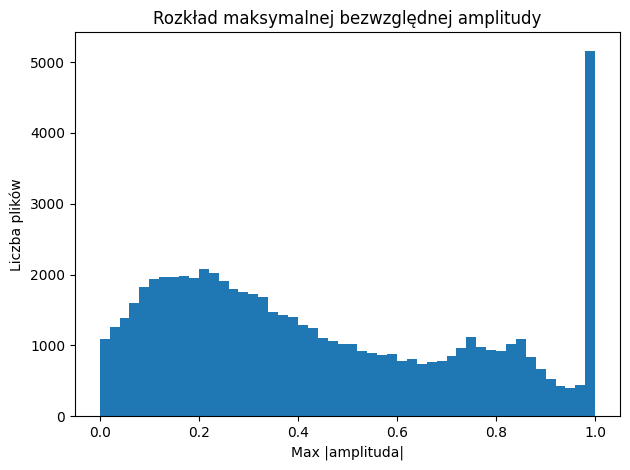

In [8]:
plt.figure()
plt.hist(df['abs_max'], bins=50)
plt.title('Rozkład maksymalnej bezwzględnej amplitudy')
plt.xlabel('Max |amplituda|')
plt.ylabel('Liczba plików')
plt.tight_layout()
plt.show()

In [9]:
# outliery amplitudy według reguły: max|amp| > 1.5*IQR to outlier

iqr = desc.loc['75%', 'abs_max'] - desc.loc['25%', 'abs_max']
threshold = desc.loc['75%', 'abs_max'] + 1.5 * iqr
outliers = df[df['abs_max'] > threshold]
print(f"\nOutliery (abs_max > {threshold:.3f}):")
print(outliers[['filename','label','abs_max']])


Outliery (abs_max > 1.469):
Empty DataFrame
Columns: [filename, label, abs_max]
Index: []


Wiekszość plików ma umiarkowany poziom głośności, jednak jest około 5000 plików o amplitudzie około 1.0, ale nie przekraczają one progu 1.5*IQR więc nie uznajemy ich jako outlierów.

# Liczności klas


Liczność przykładów w klasach:
label
unknown    41045
stop        2380
yes         2377
no          2375
up          2375
go          2372
on          2367
right       2367
down        2359
off         2357
left        2353
Name: count, dtype: int64


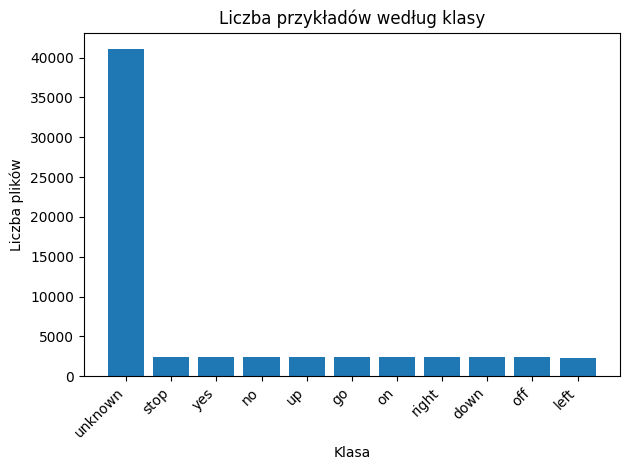

In [10]:
class_counts = df['label'].value_counts()
print("\nLiczność przykładów w klasach:")
print(class_counts)

plt.figure()
plt.bar(class_counts.index, class_counts.values)
plt.title('Liczba przykładów według klasy')
plt.xlabel('Klasa')
plt.ylabel('Liczba plików')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Najliczniejsza klasa to unknown, pozostałe są o podobnej liczności, w celu zbalansowania tego wykorzystamy undersampling

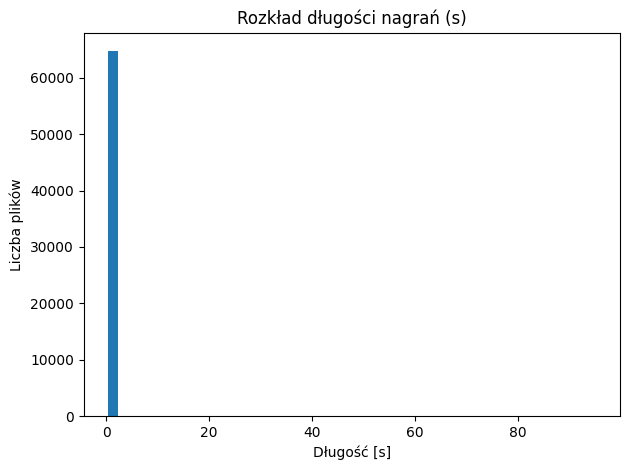

In [11]:
plt.figure()
plt.hist(df['length_s'], bins=50)
plt.title('Rozkład długości nagrań (s)')
plt.xlabel('Długość [s]')
plt.ylabel('Liczba plików')
plt.tight_layout()
plt.show()

Wszystkie nagrania są o długości około 0-2 s.

# Rysowanie spektogramów

C:\Users\monik\AppData\Local\Temp\ipykernel_26876\4104615494.py:39: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


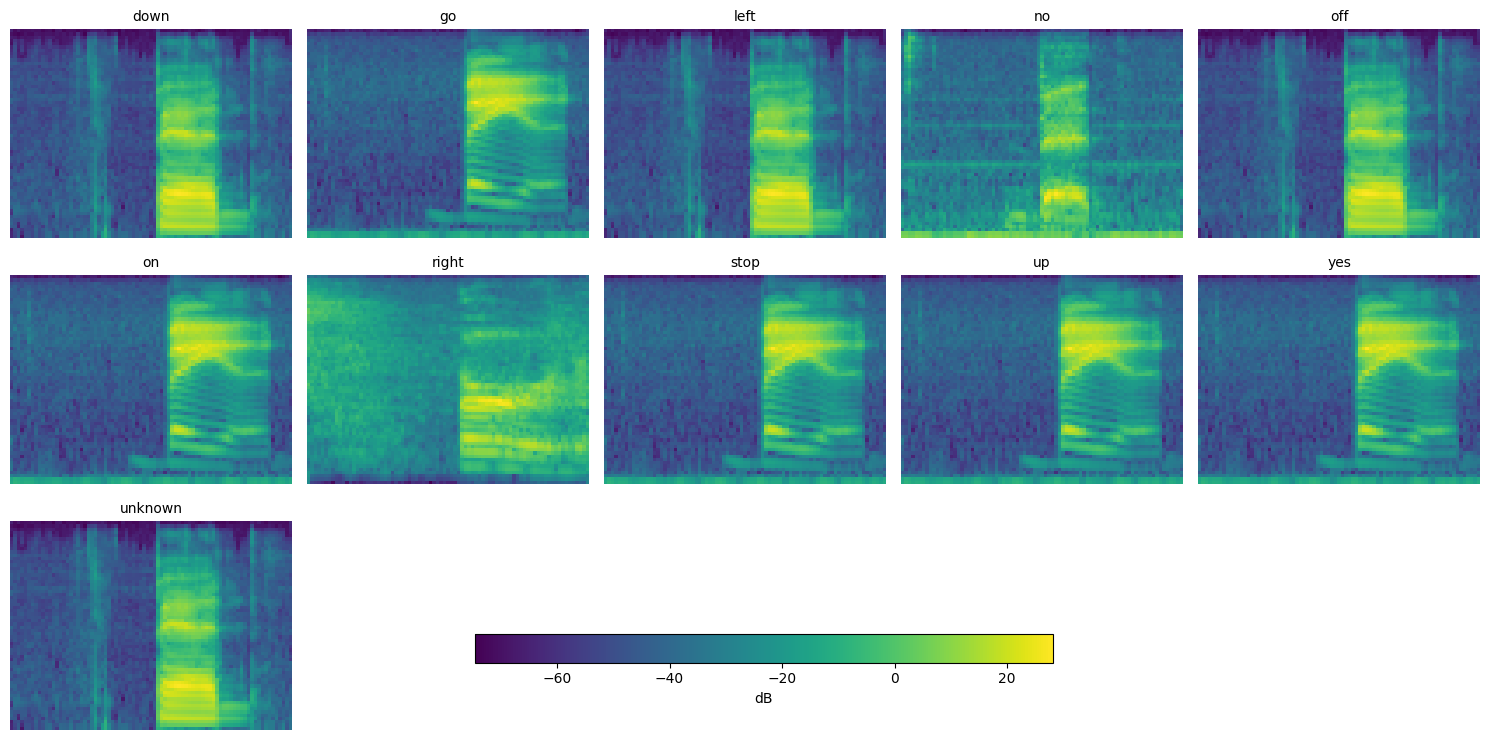

In [12]:
# Zbieranie po jednym indeksie dla każdej klasy
seen = set()
example_idxs = {}
for idx, label in enumerate(dataset.labels):
    if label not in seen:
        seen.add(label)
        example_idxs[label] = idx
    if len(seen) == len(dataset.label2idx):
        break

# Liczba klas i układ subplotów
n_classes = len(example_idxs)
cols = 5
rows = (n_classes + cols - 1) // cols

# Rysowanie
fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*2.5))
axes = axes.flatten()

for ax_i, (label, idx) in enumerate(sorted(example_idxs.items())):
    spec_db, _ = dataset[idx]
    im = axes[ax_i].imshow(
        spec_db.squeeze(0).numpy(),
        origin='lower',
        aspect='auto',
        cmap='viridis'
    )
    axes[ax_i].set_title(dataset.idx2label[label], fontsize=10)
    axes[ax_i].axis('off')

# Usuń ewentualne puste osie
for ax in axes[n_classes:]:
    ax.remove()

# Dodaj wspólną kolorbar
cbar = fig.colorbar(im, ax=axes[:n_classes], orientation='horizontal', fraction=0.05, pad=0.04)
cbar.set_label('dB')

plt.tight_layout()
plt.show()

# Analiza speakerów

In [66]:
# Scieżka do listy zbioru walidacyjnego
val_list_path = r"C:\Users\monik\OneDrive\Pulpit\Projekt_warsztaty\train\train\validation_list.txt"

In [67]:
def count_speakers_in_dir(directory):
    """Zlicza pliki WAV w katalogu <label>/* wg ID speakerów (prefix przed '_')."""
    cnt = Counter()
    for label in os.listdir(directory):
        label_dir = os.path.join(directory, label)
        if not os.path.isdir(label_dir):
            continue
        for fname in os.listdir(label_dir):
            if not fname.lower().endswith(".wav"):
                continue
            speaker = fname.split("_", 1)[0]
            cnt[speaker] += 1
    return cnt

def count_speakers_from_list(root, list_path):
    """Zlicza pliki wg ścieżek w list_path (relatywne do root)."""
    cnt = Counter()
    with open(list_path, "r") as f:
        for rel in f:
            rel = rel.strip()
            if not rel:
                continue
            # rel = "label/filename.wav"
            _, fname = rel.split("/", 1)
            speaker = fname.split("_", 1)[0]
            cnt[speaker] += 1
    return cnt

In [68]:
# rain
train_counts = count_speakers_in_dir(root_dir)

# Validation
val_counts   = count_speakers_from_list(root_dir, val_list_path)

In [69]:
counts_train = list(train_counts.values())
counts_val   = list(val_counts.values())

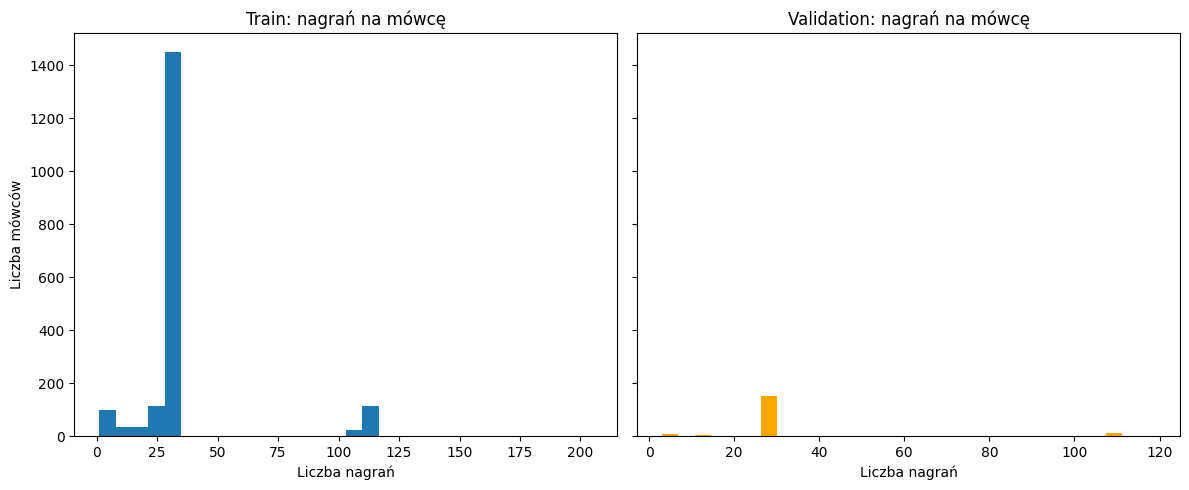

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Treningowy
axes[0].hist(counts_train, bins=30)
axes[0].set_title("Train: nagrań na mówcę")
axes[0].set_xlabel("Liczba nagrań")
axes[0].set_ylabel("Liczba mówców")

# Walidacyjny
axes[1].hist(counts_val, bins=30, color='orange')
axes[1].set_title("Validation: nagrań na mówcę")
axes[1].set_xlabel("Liczba nagrań")

plt.tight_layout()
plt.show()

In [71]:
# Lista speakerów w train
train_speakers = sorted(train_counts.keys())
print(f"Train ({len(train_speakers)} speakerów):")
for sp in train_speakers:
    print(sp)

Train (1887 speakerów):
00176480
004ae714
00b01445
00f0204f
012c8314
0132a06d
0135f3f2
0137b3f4
014f9f65
01648c51
016e2c6d
019fa366
01b4757a
01bb6a2a
01bcfc0c
01d22d03
0227998e
022cd682
023808be
023a61ad
026290a7
02746d24
02e85b60
02fcd241
030ec18b
035de8fe
0362539c
037c445a
0397ecda
03c96658
03cf93b1
042186b8
042ea76c
0447d7c1
0474c92a
0487ba9b
05739450
05b2db80
05cf43ef
05d18852
06076b6b
060cd039
0616de09
063d48cf
0685264e
069ab0d5
06a79a03
070b49af
07363607
079d1020
079dfce3
07ad9b59
07c5129e
07f7e812
0819edb0
08ab8082
090efdc4
093f65a1
095847e4
096456f9
099d52ad
09bcdc9d
09ddc105
0a0b46ae
0a7c2a8d
0a9f9af7
0ab3b47d
0ac15fe9
0b09edd3
0b40aa8e
0b56bcfe
0b77ee66
0bd689d7
0bde966a
0c2ca723
0c2d2ffa
0c40e715
0c5027de
0cd323ec
0d2bcf9d
0d393936
0d53e045
0d97f020
0e17f595
0e4d22f1
0e5193e6
0ea0e2f4
0eb48e10
0f250098
0f3f64d5
0f7205ef
0f7dc557
0fa1e7a9
0ff728b5
102192fd
10467b06
105a0eea
105e72bb
10627519
106a6183
107bc341
1093c8e7
10ace7eb
10c6d873
10f2bb12
11099149
11321027
11379f4d
1182

In [72]:
# Lista speakerów w validation
val_speakers = sorted(val_counts.keys())
print(f"\nValidation ({len(val_speakers)} speakerów):")
for sp in val_speakers:
    print(sp)


Validation (189 speakerów):
026290a7
060cd039
099d52ad
0ab3b47d
0e17f595
105e72bb
10f2bb12
1657c9fa
16db1582
171b56dc
1816b768
1942abd7
19b05529
1a9afd33
1aed7c6d
1bc45db9
2296b1af
22aa3665
23ad12d8
257e17e0
258f4559
2643992f
264f471d
27b9a84f
28ef2a01
29b81b73
2a89ad5c
2ce7534c
2d056836
2e0d80f7
364c0853
3903b558
3aa6f4e2
3b853f44
3bdf05d3
3ca784ec
3e2ba5f7
409c962a
41285056
439c84f4
44bc77f7
44c201dd
471a0925
48bfde8e
4abefdf5
50ed8a7b
50f55535
52bfbce8
52e228e9
538e1856
53d5b86f
541120c7
54d9ccb5
56eb74ae
57cb3575
591d32f3
5fadb538
605ed0ff
6071a214
61bcb275
62641b88
638685f2
65ec06e5
66774579
66cff190
67c7fecb
6940f7f3
6a27a9bf
6b81fead
6c0f6493
6d0ad764
6d818f6c
6f5b4d3d
7117fb6d
7195ffa6
750e3e75
794cdfc5
7be5a0f3
7c1d8533
7ca023e2
7eee5973
7fd25f7c
826268f8
8335f893
8523766b
86402da1
86478fab
8843b25f
88f8a99c
8910e5ef
8a5acefd
8b775397
90804775
9190045a
91d5933a
936de313
962f27eb
96c67073
97ae8b25
989a2213
9cde5de8
9d32f10a
9db2bfe9
a1dd919f
a6d586b7
a7dd45cf
a8cf01bc
a9f38bae

In [73]:
print("Liczba unikalnych speakerów w zbiorze treningowym:", len(train_counts))
print("Liczba unikalnych speakerów w zbiorze walidacyjnym:", len(val_counts))

Liczba unikalnych speakerów w zbiorze treningowym: 1887
Liczba unikalnych speakerów w zbiorze walidacyjnym: 189


## Histogram recordingów na speakerów

In [122]:
# Przedziały (bins) do histogramu
base_bins = [1, 10, 25, 50, 100, 125, 150]
max_edge = np.array(counts_train).max() + 1
bins = sorted(set(base_bins + [max_edge]))

In [123]:
# Zbiór treningowy

# Histogram
hist_train, edges_train = np.histogram(counts_train, bins=bins)

# Tabela przedziałów i liczby speakerów w każdym przedziale
for i in range(len(hist_train)):
    low = edges_train[i]
    high = edges_train[i+1] - 1
    print(f"{int(low):>4}–{int(high):>4} nagrań: {hist_train[i]:>5} speakerów")

   1–   9 nagrań:   112 speakerów
  10–  24 nagrań:    72 speakerów
  25–  49 nagrań:  1548 speakerów
  50–  99 nagrań:     7 speakerów
 100– 124 nagrań:   143 speakerów
 125– 149 nagrań:     1 speakerów
 150– 205 nagrań:     4 speakerów


In [124]:
# Zbiór walidacyjny

# Histogram
hist_val, edges_val = np.histogram(counts_val, bins=bins)

# Tabela przedziałów i liczby speakerów w każdym przedziale
for i in range(len(hist_val)):
    low = edges_val[i]
    high = edges_val[i+1] - 1
    print(f"{int(low):>4}–{int(high):>4} nagrań: {hist_val[i]:>5} speakerów")

   1–   9 nagrań:     9 speakerów
  10–  24 nagrań:     9 speakerów
  25–  49 nagrań:   152 speakerów
  50–  99 nagrań:     1 speakerów
 100– 124 nagrań:    18 speakerów
 125– 149 nagrań:     0 speakerów
 150– 205 nagrań:     0 speakerów


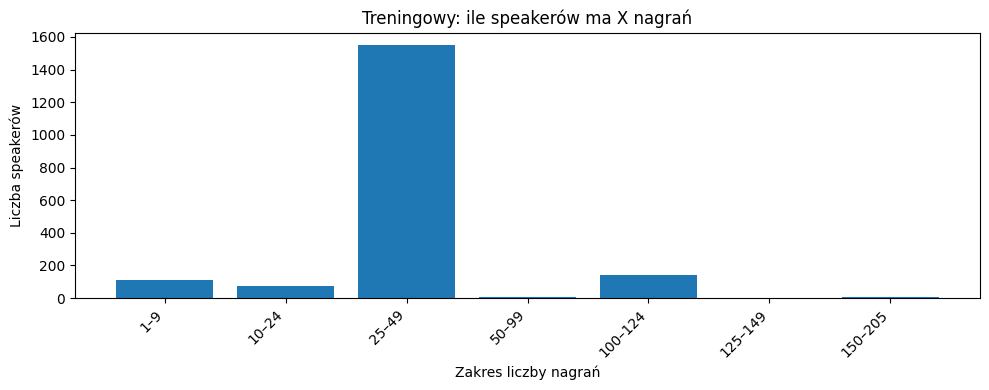

In [125]:
labels_train = [f"{int(edges_train[i])}–{int(edges_train[i+1]-1)}" for i in range(len(hist_train))]

plt.figure(figsize=(10,4))
plt.bar(labels_train, hist_train)
plt.xticks(rotation=45, ha='right')
plt.title("Treningowy: ile speakerów ma X nagrań")
plt.xlabel("Zakres liczby nagrań")
plt.ylabel("Liczba speakerów")
plt.tight_layout()
plt.show()

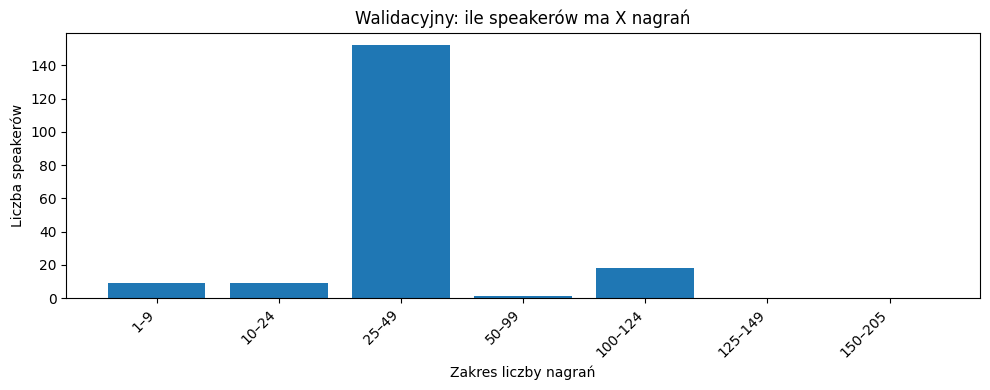

In [126]:
labels_val = [f"{int(edges_val[i])}–{int(edges_val[i+1]-1)}" for i in range(len(hist_val))]

plt.figure(figsize=(10,4))
plt.bar(labels_val, hist_val)
plt.xticks(rotation=45, ha='right')
plt.title("Walidacyjny: ile speakerów ma X nagrań")
plt.xlabel("Zakres liczby nagrań")
plt.ylabel("Liczba speakerów")
plt.tight_layout()
plt.show()

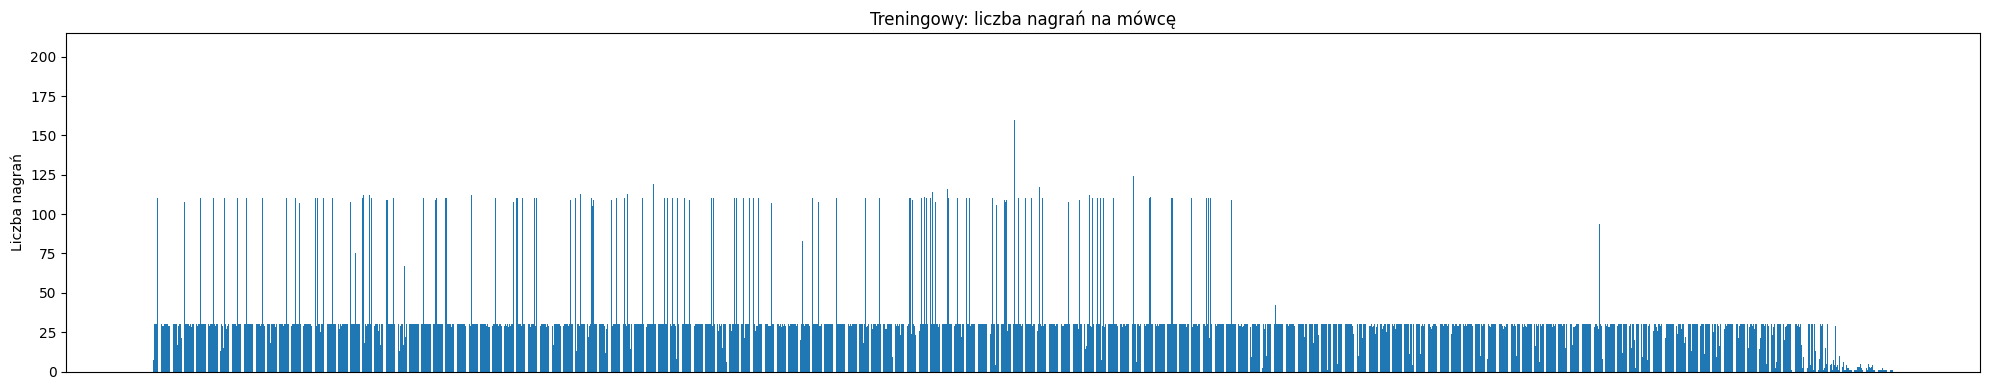

In [96]:
# train_counts to Counter z liczbą nagrań na speakera
speakers = list(train_counts.keys())
counts   = list(train_counts.values())

plt.figure(figsize=(20,4))
plt.bar(range(len(speakers)), counts)  
plt.title("Treningowy: liczba nagrań na mówcę")
plt.ylabel("Liczba nagrań")
plt.xticks([],[])               
plt.tight_layout()
plt.show()

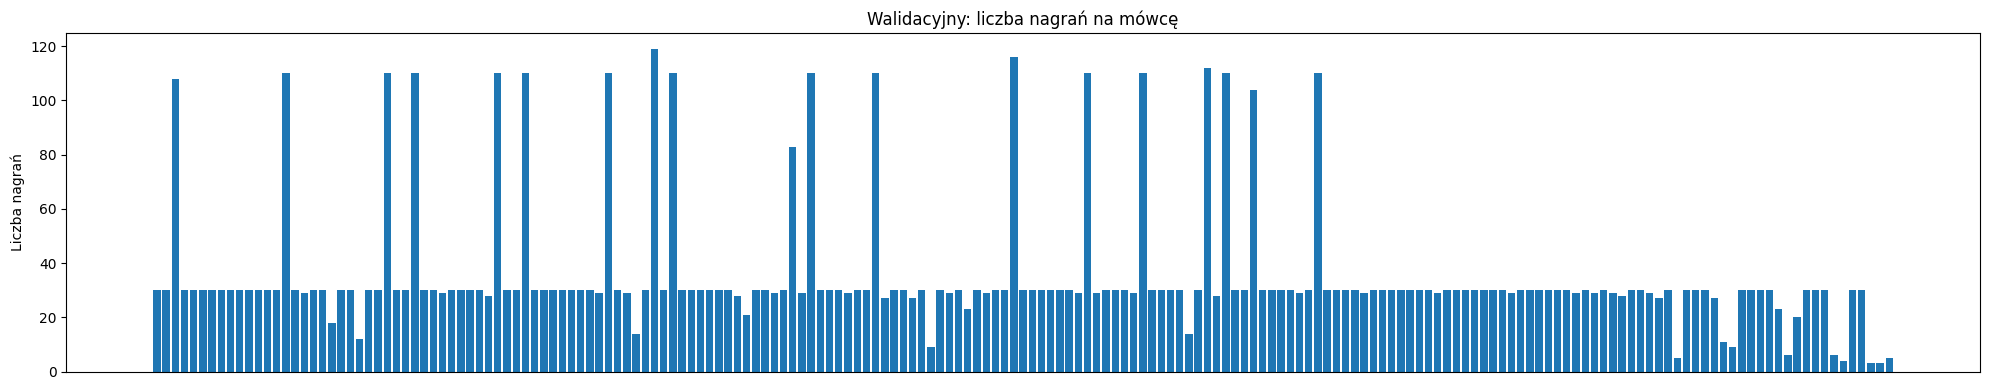

In [95]:
# train_counts to Counter z liczbą nagrań na speakera
speakers = list(val_counts.keys())
counts   = list(val_counts.values())

plt.figure(figsize=(20,4))
plt.bar(range(len(speakers)), counts)       
plt.title("Walidacyjny: liczba nagrań na mówcę")
plt.ylabel("Liczba nagrań")
plt.xticks([],[])               
plt.tight_layout()
plt.show()